In [1]:
%cd ../..

/home/eli/AnacondaProjects/combinators


In [2]:
import logging

import numpy as np
import probtorch
import torch

from examples.dynamical_ball import dynamical_ball
from examples.bouncing_ball import bouncing_ball_data
from combinators.model import foldable
from combinators.inference import importance, mcmc
from combinators import utils

In [3]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [5]:
## dataset parameters
T = 100 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [6]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [7]:
num_particles = (100,)

In [8]:
init_bouncing_ball = dynamical_ball.InitBallDynamics(batch_shape=num_particles)

In [9]:
bouncing_ball_step = dynamical_ball.StepBallDynamics(batch_shape=num_particles)

In [10]:
def generate_trajectory_trace(s):
    trajectory = torch.Tensor(STATEs[s])
    displacements = torch.Tensor(Disps[s])

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = torch.Tensor(point[:2])
        if i >= 1:
            data['velocity_%d' % (i-1)] = displacements[i-1]
    
    return trajectory, displacements, data

In [11]:
def accumulate_trajectory(inference):
    initial_position = inference['Reduce/Step(0)/InitBallDynamics']['position_0'].value
    initial_velocity = inference['Reduce/Step(0)/InitBallDynamics']['velocity_0'].value
    velocities = torch.zeros(initial_velocity.shape[0], T + 1, 2)
    velocities[:, 0] = initial_velocity
    for t in range(1, T + 1):
        velocities[:, t] = inference['Reduce/Step(%d)/StepBallDynamics' % (t-1)]['velocity_%d' % t].value
    trajectory = dynamical_ball.simulate_trajectory(initial_position, initial_velocity, T, velocities=velocities)
    return trajectory[:, :, 0, :]

In [12]:
def graph_trajectory(positions, T, s, name, show=True):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T+1))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    if show:
        plt.show()
    else:
        plt.savefig(name % s)

In [13]:
def graph_original_trajectory(trajectory, T, s, show=True):
    positions = trajectory[:, :2]
    graph_trajectory(positions, T, s, 'trajectory_%d.pdf', show=show)

In [14]:
def graph_inferred_trajectory(positions, T, s, show=True):
    graph_trajectory(positions, T, s, 'inferred_trajectory_%d.pdf', show=show)

In [15]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [16]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [17]:
def proposal_model():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return foldable.Reduce(foldable.Step(step_proposal, initializer=init_proposal),
                           lambda: range(T))

In [18]:
def training_initializer():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    return importance.Propose(init_bouncing_ball, init_proposal)

In [19]:
def training_step():
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return importance.Propose(bouncing_ball_step, step_proposal)

In [20]:
def training_model():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    proposal = foldable.Reduce(foldable.Step(step_proposal, initializer=init_proposal), lambda: range(T))
    target = foldable.reduce(foldable.Step(bouncing_ball_step, initializer=init_bouncing_ball), lambda: range(T))
    return importance.Propose(target, proposal)

06/13/2019 11:38:33 ELBO=-4.32399261e+02 at epoch 1
06/13/2019 11:38:33 ELBO=-4.29168823e+02 at epoch 2
06/13/2019 11:38:34 ELBO=-4.50992310e+02 at epoch 3
06/13/2019 11:38:34 ELBO=-4.26611206e+02 at epoch 4
06/13/2019 11:38:35 ELBO=-4.33184509e+02 at epoch 5
06/13/2019 11:38:35 ELBO=-4.01939728e+02 at epoch 6
06/13/2019 11:38:36 ELBO=-4.32668060e+02 at epoch 7
06/13/2019 11:38:36 ELBO=-4.25458771e+02 at epoch 8
06/13/2019 11:38:36 ELBO=-4.16942200e+02 at epoch 9
06/13/2019 11:38:37 ELBO=-4.38958893e+02 at epoch 10
06/13/2019 11:38:37 ELBO=-4.18973267e+02 at epoch 11
06/13/2019 11:38:38 ELBO=-4.11446808e+02 at epoch 12
06/13/2019 11:38:38 ELBO=-4.21983185e+02 at epoch 13
06/13/2019 11:38:39 ELBO=-4.23243408e+02 at epoch 14
06/13/2019 11:38:39 ELBO=-3.70437592e+02 at epoch 15
06/13/2019 11:38:40 ELBO=-3.95757355e+02 at epoch 16
06/13/2019 11:38:40 ELBO=-3.81823914e+02 at epoch 17
06/13/2019 11:38:41 ELBO=-3.81125824e+02 at epoch 18
06/13/2019 11:38:41 ELBO=-3.73563995e+02 at epoch 19
06

Epoch   239: reducing learning rate of group 0 to 5.0000e-02.


06/13/2019 11:40:25 ELBO=-1.42669983e+02 at epoch 241
06/13/2019 11:40:25 ELBO=-1.26502609e+02 at epoch 242
06/13/2019 11:40:26 ELBO=-1.58813263e+02 at epoch 243
06/13/2019 11:40:26 ELBO=-7.90050659e+01 at epoch 244
06/13/2019 11:40:27 ELBO=-1.10365303e+02 at epoch 245
06/13/2019 11:40:27 ELBO=-6.35572510e+01 at epoch 246
06/13/2019 11:40:28 ELBO=-1.39643875e+02 at epoch 247
06/13/2019 11:40:28 ELBO=-1.27669327e+02 at epoch 248
06/13/2019 11:40:28 ELBO=-1.21381897e+02 at epoch 249
06/13/2019 11:40:29 ELBO=-1.08103638e+02 at epoch 250
06/13/2019 11:40:29 ELBO=-4.89943085e+01 at epoch 251
06/13/2019 11:40:30 ELBO=-1.36911697e+02 at epoch 252
06/13/2019 11:40:30 ELBO=-1.21464836e+02 at epoch 253
06/13/2019 11:40:31 ELBO=-1.39597351e+02 at epoch 254
06/13/2019 11:40:31 ELBO=-1.20417572e+02 at epoch 255
06/13/2019 11:40:32 ELBO=-1.23134476e+02 at epoch 256
06/13/2019 11:40:32 ELBO=-5.90642853e+01 at epoch 257
06/13/2019 11:40:33 ELBO=-1.38608429e+02 at epoch 258
06/13/2019 11:40:33 ELBO=-1.

Epoch   401: reducing learning rate of group 0 to 2.5000e-02.


06/13/2019 11:41:39 ELBO=-9.32785950e+01 at epoch 403
06/13/2019 11:41:40 ELBO=-1.05419769e+02 at epoch 404
06/13/2019 11:41:40 ELBO=-1.14011536e+02 at epoch 405
06/13/2019 11:41:41 ELBO=-1.09049019e+02 at epoch 406
06/13/2019 11:41:41 ELBO=-1.11951256e+02 at epoch 407
06/13/2019 11:41:42 ELBO=-5.13402176e+01 at epoch 408
06/13/2019 11:41:42 ELBO=-5.41627197e+01 at epoch 409
06/13/2019 11:41:42 ELBO=-1.07045914e+02 at epoch 410
06/13/2019 11:41:43 ELBO=-6.40360031e+01 at epoch 411
06/13/2019 11:41:43 ELBO=-9.27461090e+01 at epoch 412
06/13/2019 11:41:44 ELBO=-1.02322594e+02 at epoch 413
06/13/2019 11:41:44 ELBO=-6.05008698e+01 at epoch 414
06/13/2019 11:41:45 ELBO=-9.96300583e+01 at epoch 415
06/13/2019 11:41:45 ELBO=-7.47464905e+01 at epoch 416
06/13/2019 11:41:46 ELBO=-9.96952057e+01 at epoch 417
06/13/2019 11:41:46 ELBO=-8.31427383e+01 at epoch 418
06/13/2019 11:41:46 ELBO=-9.72585144e+01 at epoch 419
06/13/2019 11:41:47 ELBO=-5.54911766e+01 at epoch 420
06/13/2019 11:41:47 ELBO=-5.

Epoch   615: reducing learning rate of group 0 to 1.2500e-02.


06/13/2019 11:43:16 ELBO=-8.35288162e+01 at epoch 617
06/13/2019 11:43:17 ELBO=-9.09400177e+01 at epoch 618
06/13/2019 11:43:17 ELBO=-3.46316185e+01 at epoch 619
06/13/2019 11:43:17 ELBO=-5.69119034e+01 at epoch 620
06/13/2019 11:43:18 ELBO=-8.96752090e+01 at epoch 621
06/13/2019 11:43:18 ELBO=-5.97853661e+01 at epoch 622
06/13/2019 11:43:19 ELBO=-6.85182571e+01 at epoch 623
06/13/2019 11:43:19 ELBO=-5.92348061e+01 at epoch 624
06/13/2019 11:43:20 ELBO=-8.31570435e+01 at epoch 625
06/13/2019 11:43:20 ELBO=-7.72645645e+01 at epoch 626
06/13/2019 11:43:21 ELBO=-4.42567825e+01 at epoch 627
06/13/2019 11:43:21 ELBO=-4.07658081e+01 at epoch 628
06/13/2019 11:43:22 ELBO=-8.06590347e+01 at epoch 629
06/13/2019 11:43:22 ELBO=-7.80008316e+01 at epoch 630
06/13/2019 11:43:23 ELBO=-8.84149017e+01 at epoch 631
06/13/2019 11:43:23 ELBO=-7.56534653e+01 at epoch 632
06/13/2019 11:43:23 ELBO=-6.92511902e+01 at epoch 633
06/13/2019 11:43:24 ELBO=-9.04188766e+01 at epoch 634
06/13/2019 11:43:24 ELBO=-7.

Epoch   716: reducing learning rate of group 0 to 6.2500e-03.


06/13/2019 11:44:02 ELBO=-6.47380829e+01 at epoch 718
06/13/2019 11:44:03 ELBO=-7.69830780e+01 at epoch 719
06/13/2019 11:44:03 ELBO=-3.15339031e+01 at epoch 720
06/13/2019 11:44:03 ELBO=-5.75373611e+01 at epoch 721
06/13/2019 11:44:04 ELBO=-7.07574310e+01 at epoch 722
06/13/2019 11:44:04 ELBO=-7.21989136e+01 at epoch 723
06/13/2019 11:44:05 ELBO=-6.91716309e+01 at epoch 724
06/13/2019 11:44:05 ELBO=-3.17128372e+01 at epoch 725
06/13/2019 11:44:06 ELBO=-5.78789635e+01 at epoch 726
06/13/2019 11:44:06 ELBO=-7.92385559e+01 at epoch 727
06/13/2019 11:44:07 ELBO=-4.01067085e+01 at epoch 728
06/13/2019 11:44:07 ELBO=-4.91206856e+01 at epoch 729
06/13/2019 11:44:08 ELBO=-7.59072189e+01 at epoch 730
06/13/2019 11:44:08 ELBO=-8.03232498e+01 at epoch 731
06/13/2019 11:44:09 ELBO=-7.81001892e+01 at epoch 732
06/13/2019 11:44:09 ELBO=-6.65629044e+01 at epoch 733
06/13/2019 11:44:10 ELBO=-7.73916779e+01 at epoch 734
06/13/2019 11:44:10 ELBO=-3.39686279e+01 at epoch 735
06/13/2019 11:44:10 ELBO=-7.

Epoch   849: reducing learning rate of group 0 to 3.1250e-03.


06/13/2019 11:45:04 ELBO=-7.82780228e+01 at epoch 851
06/13/2019 11:45:05 ELBO=-7.46442871e+01 at epoch 852
06/13/2019 11:45:05 ELBO=-5.51722031e+01 at epoch 853
06/13/2019 11:45:06 ELBO=-6.72051697e+01 at epoch 854
06/13/2019 11:45:06 ELBO=-6.13520737e+01 at epoch 855
06/13/2019 11:45:07 ELBO=-4.82756271e+01 at epoch 856
06/13/2019 11:45:07 ELBO=-3.67325668e+01 at epoch 857
06/13/2019 11:45:08 ELBO=-6.89830093e+01 at epoch 858
06/13/2019 11:45:08 ELBO=-7.34715576e+01 at epoch 859
06/13/2019 11:45:09 ELBO=-5.71460953e+01 at epoch 860
06/13/2019 11:45:09 ELBO=-8.13285980e+01 at epoch 861
06/13/2019 11:45:10 ELBO=-7.62193527e+01 at epoch 862
06/13/2019 11:45:10 ELBO=-2.75702667e+01 at epoch 863
06/13/2019 11:45:11 ELBO=-6.66391678e+01 at epoch 864
06/13/2019 11:45:11 ELBO=-3.01327190e+01 at epoch 865
06/13/2019 11:45:11 ELBO=-6.39946098e+01 at epoch 866
06/13/2019 11:45:12 ELBO=-6.98060837e+01 at epoch 867
06/13/2019 11:45:12 ELBO=-4.91998138e+01 at epoch 868
06/13/2019 11:45:13 ELBO=-7.

Epoch   950: reducing learning rate of group 0 to 1.5625e-03.


06/13/2019 11:45:52 ELBO=-4.41362343e+01 at epoch 952
06/13/2019 11:45:53 ELBO=-2.90335674e+01 at epoch 953
06/13/2019 11:45:53 ELBO=-6.46379471e+01 at epoch 954
06/13/2019 11:45:54 ELBO=-4.04573593e+01 at epoch 955
06/13/2019 11:45:54 ELBO=-7.44234695e+01 at epoch 956
06/13/2019 11:45:55 ELBO=-6.71718369e+01 at epoch 957
06/13/2019 11:45:55 ELBO=-6.47312622e+01 at epoch 958
06/13/2019 11:45:56 ELBO=-7.24218750e+01 at epoch 959
06/13/2019 11:45:56 ELBO=-7.44068832e+01 at epoch 960
06/13/2019 11:45:57 ELBO=-5.49772263e+01 at epoch 961
06/13/2019 11:45:57 ELBO=-6.65611801e+01 at epoch 962
06/13/2019 11:45:58 ELBO=-7.34908981e+01 at epoch 963
06/13/2019 11:45:58 ELBO=-3.79415932e+01 at epoch 964
06/13/2019 11:45:58 ELBO=-3.74800377e+01 at epoch 965
06/13/2019 11:45:59 ELBO=-7.57283707e+01 at epoch 966
06/13/2019 11:45:59 ELBO=-3.82580032e+01 at epoch 967
06/13/2019 11:46:00 ELBO=-3.71578789e+01 at epoch 968
06/13/2019 11:46:00 ELBO=-4.56177788e+01 at epoch 969
06/13/2019 11:46:01 ELBO=-7.

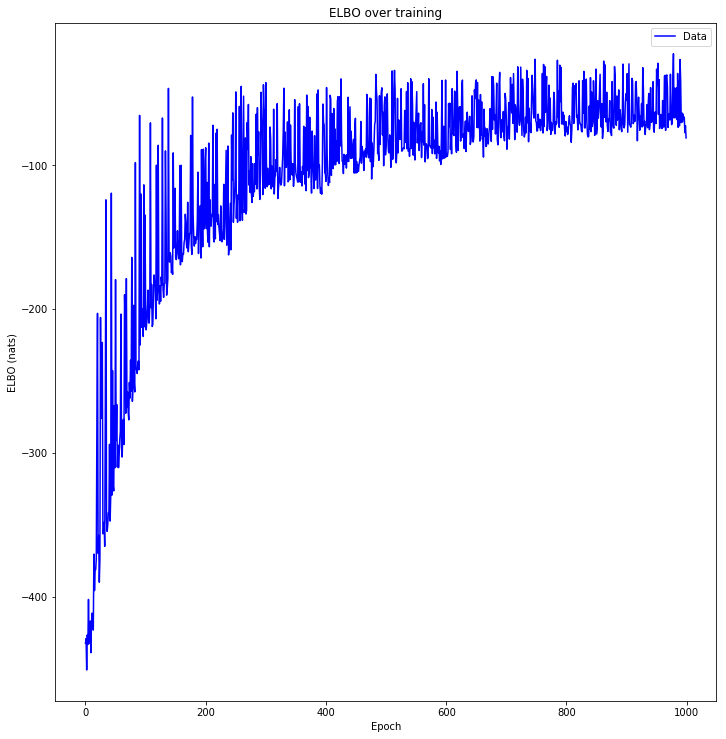

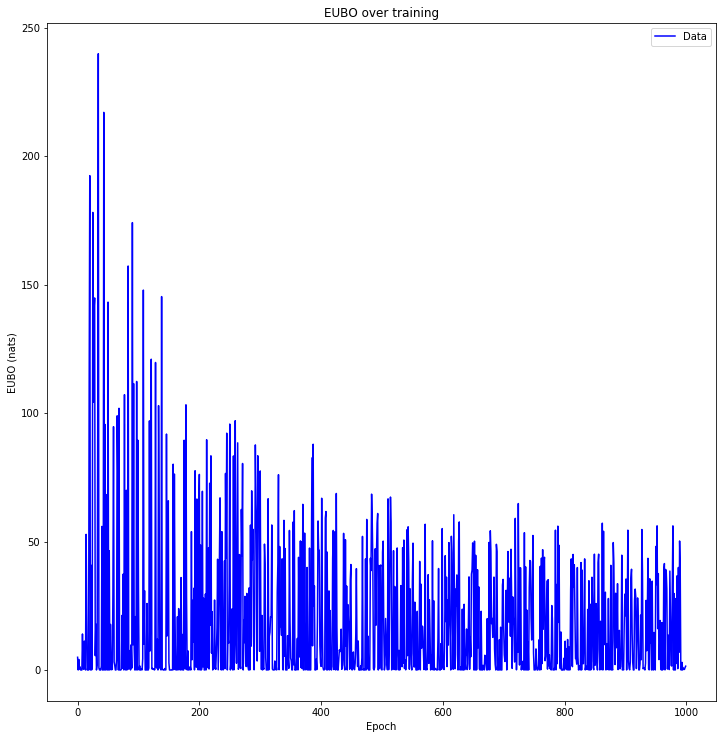

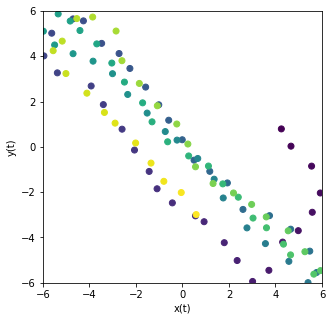

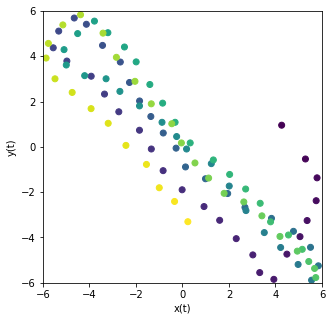

In [21]:
modal_directions = torch.zeros(num_series, K, 2)

for s in range(num_series):
    trajectory, displacements, data = generate_trajectory_trace(s)

    importance_sampler = training_model()
    
    inference, trained_params, (elbos, eubos) = importance.variational_importance(
        importance_sampler, 1000, data,
        use_cuda=True, lr=1e-1, bound='elbo',
        patience=100, log_estimator=True,
    )
    utils.plot_evidence_bounds(elbos.detach().numpy(), True)
    utils.plot_evidence_bounds(eubos.detach().numpy(), False)
    
    bouncing_ball_posterior = mcmc.resample_move_smc(importance_sampler, moves=5)
    (direction, position, uncertainty, noise), inference, _ = bouncing_ball_posterior(data=data)
    inferred_trajectory = accumulate_trajectory(inference)
    
    positions = inferred_trajectory.mean(dim=0).cpu().detach()
    displacements = torch.stack([inference['Reduce/Step(%d)/StepBallDynamics' % t]['velocity_%d' % (t+1)].value.mean(dim=0) for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)
    
    graph_original_trajectory(trajectory, T, s)
    graph_inferred_trajectory(positions, T, s)
    graph_displacement_trajectories(velocity_steps, displacements, T, s)
    
    plt.close('all')

In [22]:
trained_params

"{'noise__loc': 'tensor([-1.7347, -1.6900], grad_fn=<CloneBackward>)', 'noise__scale': 'tensor([-2.2998, -2.4142], grad_fn=<CloneBackward>)', 'position_0__covariance_matrix': 'tensor([[-1.6239,  0.0000],\n        [ 0.0272, -1.5790]], grad_fn=<CloneBackward>)', 'position_0__loc': 'tensor([3.9633, 0.7559], grad_fn=<CloneBackward>)', 'uncertainty__loc': 'tensor([-1.0904, -1.4558], grad_fn=<CloneBackward>)', 'uncertainty__scale': 'tensor([-2.3411, -2.2468], grad_fn=<CloneBackward>)', 'velocities__loc': 'tensor([[ 0.7625, -0.8793],\n        [ 0.3733, -0.9796],\n        [-0.3712, -0.8932],\n        [-0.5580, -0.8025],\n        [-0.6610, -0.7145],\n        [-0.5956, -0.9672],\n        [-0.6698, -0.6356],\n        [-0.6508,  0.8363],\n        [-0.6112,  0.8070],\n        [-0.7301,  0.7607],\n        [-0.5623,  0.4968],\n        [-0.8228,  0.5763],\n        [-0.6516,  0.6486],\n        [-0.4515,  0.7701],\n        [-0.6144,  0.8756],\n        [-0.5956,  0.9370],\n        [-0.7638,  0.9819],\n  

In [23]:
for t in range(T+1):
    print('Position at time %d' % t, data['position_%d' % t])
    print('Inferred position at time %d' % t, positions[t])
    print('MSE at time %d' % t, ((data['position_%d' % t] - positions[t])**2).sum())

Position at time 0 tensor([4.2536, 0.7946])
Inferred position at time 0 tensor([4.2669, 0.9579])
MSE at time 0 tensor(0.0268)
Position at time 1 tensor([4.6684, 0.0324])
Inferred position at time 1 tensor([ 5.2902, -0.5338])
MSE at time 1 tensor(0.7073)
Position at time 2 tensor([ 5.5542, -0.8490])
Inferred position at time 2 tensor([ 5.7893, -1.3653])
MSE at time 2 tensor(0.3219)
Position at time 3 tensor([ 5.9292, -2.0345])
Inferred position at time 3 tensor([ 5.7510, -2.3752])
MSE at time 3 tensor(0.1478)
Position at time 4 tensor([ 5.5839, -2.8860])
Inferred position at time 4 tensor([ 5.3621, -3.2516])
MSE at time 4 tensor(0.1829)
Position at time 5 tensor([ 4.9819, -3.6981])
Inferred position at time 5 tensor([ 5.0564, -3.9625])
MSE at time 5 tensor(0.0754)
Position at time 6 tensor([ 4.3092, -4.2028])
Inferred position at time 6 tensor([ 4.4927, -4.7348])
MSE at time 6 tensor(0.3167)
Position at time 7 tensor([ 3.7175, -5.4490])
Inferred position at time 7 tensor([ 3.9312, -5.84

In [24]:
bouncing_ball_smc = importance.smc(importance_sampler)
(direction, position, uncertainty, noise), inference, _ = bouncing_ball_smc(data=data)
inferred_trajectory = accumulate_trajectory(inference)
positions = inferred_trajectory.mean(dim=0).cpu().detach()

In [25]:
for t in range(T+1):
    print('Inferred position at time %d' % t, positions[t])
    print('MSE at time %d' % t, ((data['position_%d' % t] - positions[t])**2).sum())

Inferred position at time 0 tensor([4.0200, 0.7750])
MSE at time 0 tensor(0.0549)
Inferred position at time 1 tensor([4.7418, 0.0943])
MSE at time 1 tensor(0.0092)
Inferred position at time 2 tensor([ 5.3871, -0.8395])
MSE at time 2 tensor(0.0280)
Inferred position at time 3 tensor([ 5.6539, -1.6807])
MSE at time 3 tensor(0.2009)
Inferred position at time 4 tensor([ 5.4774, -2.6669])
MSE at time 4 tensor(0.0593)
Inferred position at time 5 tensor([ 4.8844, -3.3915])
MSE at time 5 tensor(0.1035)
Inferred position at time 6 tensor([ 4.2455, -4.1227])
MSE at time 6 tensor(0.0105)
Inferred position at time 7 tensor([ 3.6489, -5.0835])
MSE at time 7 tensor(0.1383)
Inferred position at time 8 tensor([ 3.1156, -5.7606])
MSE at time 8 tensor(0.0419)
Inferred position at time 9 tensor([ 2.4525, -5.1038])
MSE at time 9 tensor(0.0176)
Inferred position at time 10 tensor([ 1.7962, -4.3370])
MSE at time 10 tensor(0.0118)
Inferred position at time 11 tensor([ 0.9721, -3.7208])
MSE at time 11 tensor(

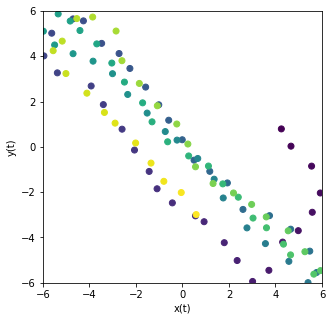

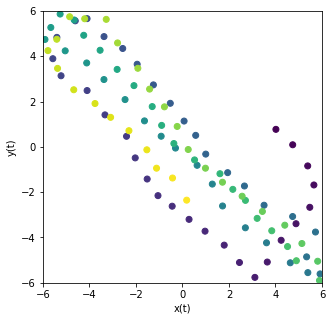

In [26]:
graph_original_trajectory(trajectory, T, s)
graph_inferred_trajectory(positions, T, s)